,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.1756,4.7580,2.1447,0.8490,0.3852,4.2196,35.1567
lightgbm,Light Gradient Boosting Machine,1.1910,5.0384,2.1961,0.8387,0.3976,3.8379,1.1433
catboost,CatBoost Regressor,1.2181,5.1023,2.2135,0.8384,0.3908,4.8107,7.4267
et,Extra Trees Regressor,1.1928,5.0473,2.1912,0.8374,0.3796,4.9544,15.4067
xgboost,Extreme Gradient Boosting,1.2314,5.2784,2.2414,0.8290,0.3946,4.8865,0.6567
rf,Random Forest Regressor,1.2261,5.3570,2.2562,0.8268,0.3887,4.7961,68.4267
knn,K Neighbors Regressor,1.3321,5.8328,2.3850,0.8136,0.4284,5.9126,0.4767
ada,AdaBoost Regressor,1.5476,6.3707,2.5026,0.8039,0.4626,11.8690,10.2200
dt,Decision Tree Regressor,1.5049,7.1394,2.6403,0.7744,0.4396,8.9303,2.4333
en,Elastic Net,1.5858,7.5931,2.7285,0.7736,0.4172,13.2564,0.6833



🌍 Multi-site model evaluated at AU-ASM:
R²:   0.6932
RMSE: 1.0833
MAE:  0.5431
ρ:    0.8352


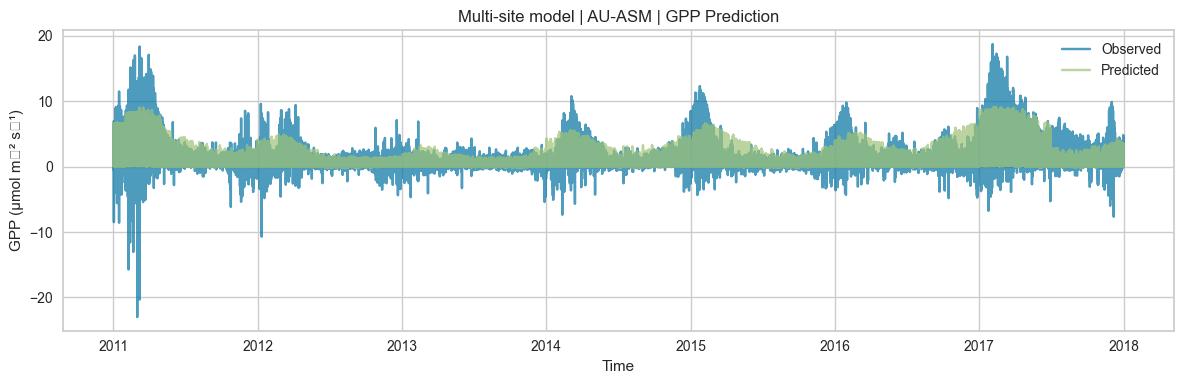


🌍 Multi-site model evaluated at FI-Hyy:
R²:   0.9266
RMSE: 1.4307
MAE:  0.8420
ρ:    0.9626


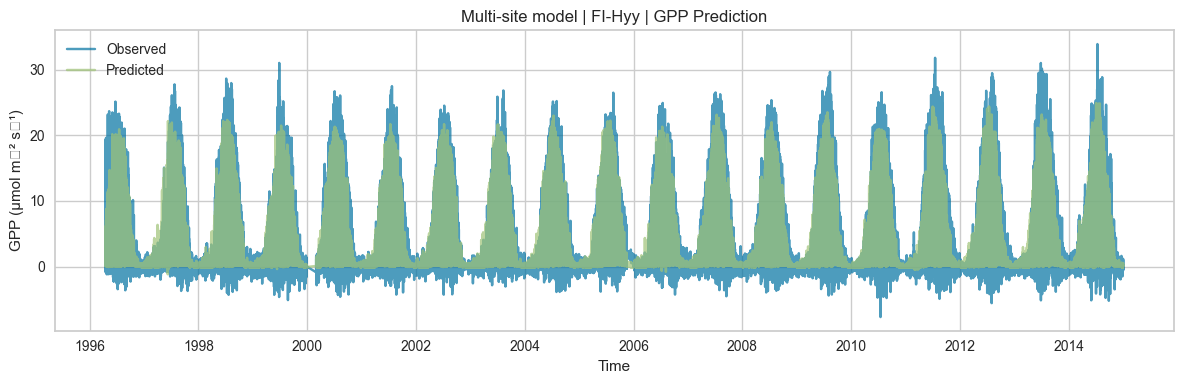


🌍 Multi-site model evaluated at US-UMB:
R²:   0.9099
RMSE: 2.1884
MAE:  1.2056
ρ:    0.9540


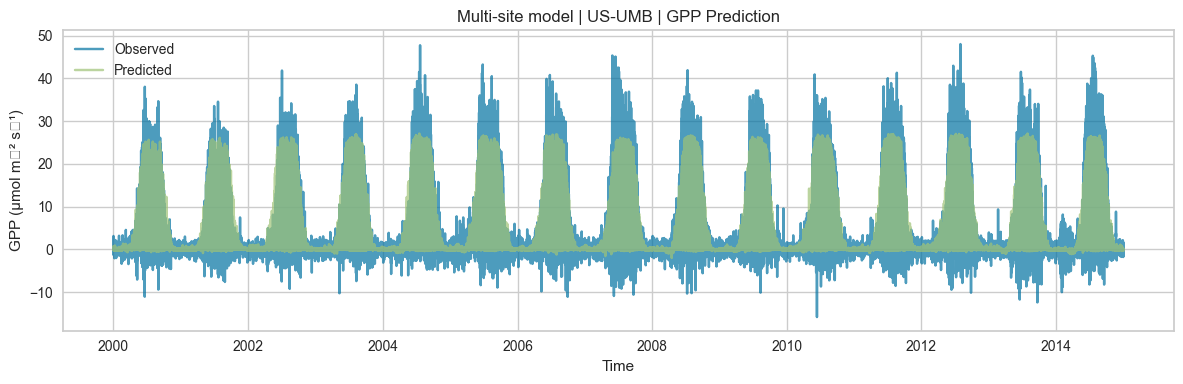

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# ========================== 1. Data loading ==========================

au_met = xr.open_dataset("AU-ASM/AU-ASM_2011-2017_OzFlux_Met.nc")
au_flux = xr.open_dataset("AU-ASM/AU-ASM_2011-2017_OzFlux_Flux.nc")

fi_met = xr.open_dataset("FI-Hyy/FI-Hyy_1996-2014_FLUXNET2015_Met.nc")
fi_flux = xr.open_dataset("FI-Hyy/FI-Hyy_1996-2014_FLUXNET2015_Flux.nc")

us_met = xr.open_dataset("US-UMB/US-UMB_2000-2014_FLUXNET2015_Met.nc")
us_flux = xr.open_dataset("US-UMB/US-UMB_2000-2014_FLUXNET2015_Flux.nc")

# ========================== 2. Feature definitions ==========================

features_raw = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf', 'Wind',
                'CO2air', 'VPD', 'LAI', 'Ustar']
derived_features = ['SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']
geo_features = ['latitude', 'longitude']
target_var = 'GPP'

# ========================== 3. Preprocessing ==========================

def preprocess(met_ds, flux_ds, lat, lon):
    met_df = met_ds.to_dataframe().reset_index()
    flux_df = flux_ds.to_dataframe().reset_index()
    df = pd.merge_asof(met_df.sort_values('time'),
                       flux_df.sort_values('time'),
                       on='time')
    df = df[['time'] + features_raw + ['GPP', 'NEE']].dropna()

    # Derived features
    df['SW_LAI'] = df['SWdown'] * df['LAI']
    df['RH_Tair'] = df['RH'] * df['Tair']
    df['SWdown_lag1'] = df['SWdown'].shift(1)
    df['Tair_lag1'] = df['Tair'].shift(1)

    # Add site geolocation
    df['latitude'] = lat
    df['longitude'] = lon

    df = df.dropna().set_index('time').sort_index()
    return df

# ========================== 4. Build combined training data ==========================

df_au = preprocess(au_met, au_flux, lat=-22.283, lon=133.249)
df_fi = preprocess(fi_met, fi_flux, lat=61.85,  lon=24.3)
df_us = preprocess(us_met, us_flux, lat=45.55,  lon=-84.71)

df_all = pd.concat([df_au, df_fi, df_us], axis=0).reset_index(drop=True)
features_all = features_raw + derived_features + geo_features

# ========================== 5. AutoML training ==========================

s = setup(
    data=pd.concat([df_all[features_all], df_all[target_var]], axis=1),
    target=target_var,
    session_id=42,
    train_size=0.95,
    fold_strategy='timeseries',
    fold=3,
    fold_shuffle=False,
    data_split_shuffle=False,
    preprocess=True,
    numeric_features=features_all,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    verbose=False
)

best_model = compare_models(sort='R2')

# ========================== 6. Site-wise generalization evaluation ==========================

def evaluate_site(df_site, name):
    test_X = df_site[features_all].reset_index(drop=True)
    test_y = df_site[target_var].reset_index(drop=True)

    preds = predict_model(best_model, data=test_X)
    y_pred = preds['prediction_label'].values
    y_true = test_y.values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    rho, _ = pearsonr(y_true, y_pred)

    print(f"\n🌍 Multi-site model evaluated at {name}:")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"ρ:    {rho:.4f}")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.plot(df_site.index, y_true, label="Observed",  alpha=0.7)
    plt.plot(df_site.index, y_pred, label="Predicted", alpha=0.7)
    plt.title(f"Multi-site model | {name} | {target_var} Prediction")
    plt.xlabel("Time")
    plt.ylabel(f"{target_var} (μmol m⁻² s⁻¹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

evaluate_site(df_au, "AU-ASM")
evaluate_site(df_fi, "FI-Hyy")
evaluate_site(df_us, "US-UMB")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.1976,4.1034,1.9928,0.8151,0.3987,2.5931,33.6567
lightgbm,Light Gradient Boosting Machine,1.1765,4.1231,1.9897,0.8140,0.3962,2.2685,0.8800
catboost,CatBoost Regressor,1.1758,4.1460,1.9993,0.8130,0.3879,2.2891,5.2133
et,Extra Trees Regressor,1.1793,4.3080,2.0276,0.8038,0.3867,2.2414,11.0400
xgboost,Extreme Gradient Boosting,1.2520,4.4390,2.0629,0.7989,0.4106,2.4756,0.7900
rf,Random Forest Regressor,1.2345,4.4898,2.0731,0.7950,0.4074,2.3138,49.7733
knn,K Neighbors Regressor,1.4387,5.2333,2.2623,0.7655,0.4703,2.8796,0.5633
br,Bayesian Ridge,1.5095,6.2022,2.4626,0.7330,0.4658,2.4050,0.1933
lr,Linear Regression,1.5158,6.2364,2.4697,0.7312,0.4671,2.3974,1.0667
ridge,Ridge Regression,1.5117,6.2545,2.4717,0.7312,0.4628,2.3998,0.5567



🌍 Multi-site model evaluated at AU-ASM:
R²:   0.6355
RMSE: 1.1240
MAE:  0.7092
ρ:    0.8013


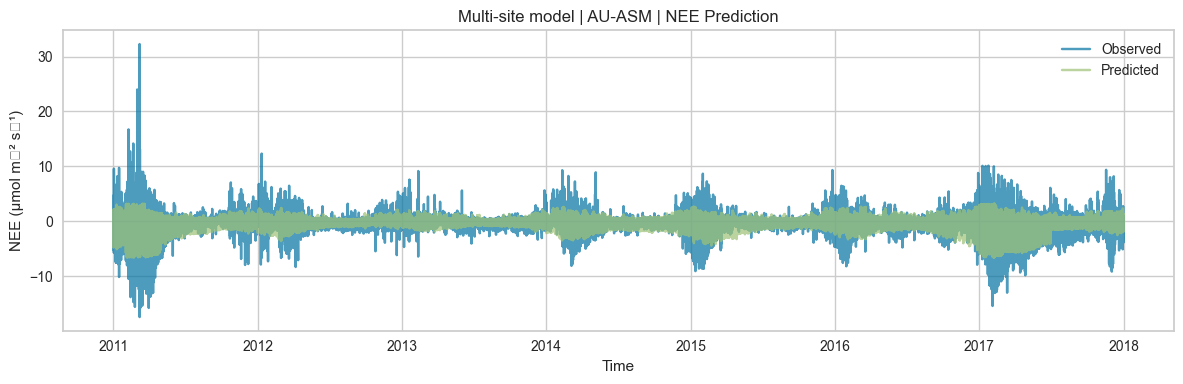


🌍 Multi-site model evaluated at FI-Hyy:
R²:   0.8986
RMSE: 1.3759
MAE:  0.8709
ρ:    0.9481


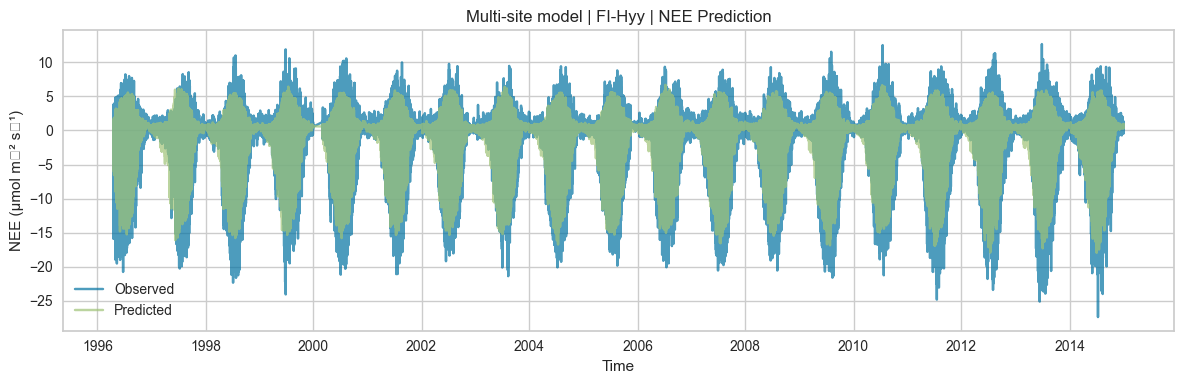


🌍 Multi-site model evaluated at US-UMB:
R²:   0.8869
RMSE: 2.1109
MAE:  1.2033
ρ:    0.9420


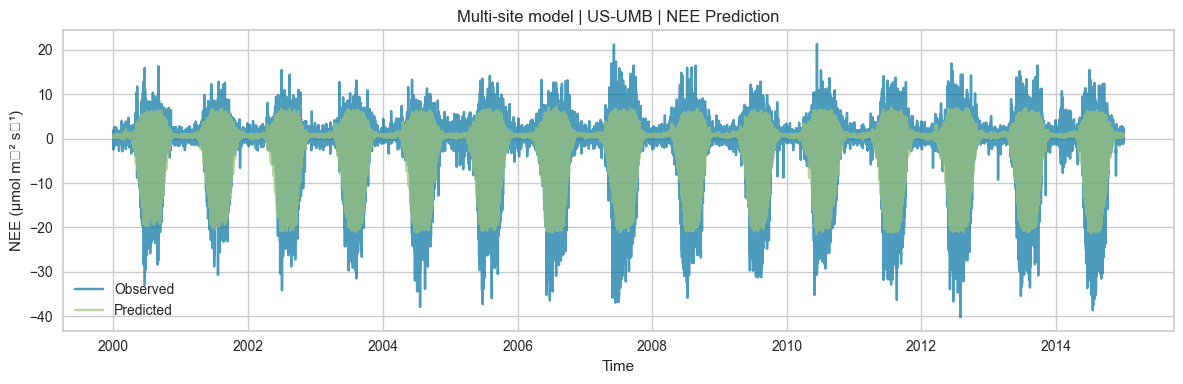

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# ========================== 1. Data loading ==========================

au_met = xr.open_dataset("AU-ASM/AU-ASM_2011-2017_OzFlux_Met.nc")
au_flux = xr.open_dataset("AU-ASM/AU-ASM_2011-2017_OzFlux_Flux.nc")

fi_met = xr.open_dataset("FI-Hyy/FI-Hyy_1996-2014_FLUXNET2015_Met.nc")
fi_flux = xr.open_dataset("FI-Hyy/FI-Hyy_1996-2014_FLUXNET2015_Flux.nc")

us_met = xr.open_dataset("US-UMB/US-UMB_2000-2014_FLUXNET2015_Met.nc")
us_flux = xr.open_dataset("US-UMB/US-UMB_2000-2014_FLUXNET2015_Flux.nc")

# ========================== 2. Feature definitions ==========================

features_raw = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf', 'Wind',
                'CO2air', 'VPD', 'LAI', 'Ustar']
derived_features = ['SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']
geo_features = ['latitude', 'longitude']
target_var = 'NEE'

# ========================== 3. Preprocessing ==========================

def preprocess(met_ds, flux_ds, lat, lon):
    met_df = met_ds.to_dataframe().reset_index()
    flux_df = flux_ds.to_dataframe().reset_index()
    df = pd.merge_asof(met_df.sort_values('time'),
                       flux_df.sort_values('time'),
                       on='time')
    df = df[['time'] + features_raw + ['GPP', 'NEE']].dropna()

    # Derived features
    df['SW_LAI'] = df['SWdown'] * df['LAI']
    df['RH_Tair'] = df['RH'] * df['Tair']
    df['SWdown_lag1'] = df['SWdown'].shift(1)
    df['Tair_lag1'] = df['Tair'].shift(1)

    # Add site geolocation
    df['latitude'] = lat
    df['longitude'] = lon

    df = df.dropna().set_index('time').sort_index()
    return df

# ========================== 4. Build combined training data ==========================

df_au = preprocess(au_met, au_flux, lat=-22.283, lon=133.249)
df_fi = preprocess(fi_met, fi_flux, lat=61.85,  lon=24.3)
df_us = preprocess(us_met, us_flux, lat=45.55,  lon=-84.71)

df_all = pd.concat([df_au, df_fi, df_us], axis=0).reset_index(drop=True)
features_all = features_raw + derived_features + geo_features

# ========================== 5. AutoML training ==========================

s = setup(
    data=pd.concat([df_all[features_all], df_all[target_var]], axis=1),
    target=target_var,
    session_id=42,
    train_size=0.95,
    fold_strategy='timeseries',
    fold=3,
    fold_shuffle=False,
    data_split_shuffle=False,
    preprocess=True,
    numeric_features=features_all,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    verbose=False
)

best_model = compare_models(sort='R2')

# ========================== 6. Site-wise generalization evaluation ==========================

def evaluate_site(df_site, name):
    test_X = df_site[features_all].reset_index(drop=True)
    test_y = df_site[target_var].reset_index(drop=True)
    preds = predict_model(best_model, data=test_X)
    y_pred = preds['prediction_label'].values
    y_true = test_y.values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    rho, _ = pearsonr(y_true, y_pred)

    print(f"\n🌍 Multi-site model evaluated at {name}:")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"ρ:    {rho:.4f}")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.plot(df_site.index, y_true, label="Observed",  alpha=0.7)
    plt.plot(df_site.index, y_pred, label="Predicted", alpha=0.7)
    plt.title(f"Multi-site model | {name} | {target_var} Prediction")
    plt.xlabel("Time")
    plt.ylabel(f"{target_var} (μmol m⁻² s⁻¹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

evaluate_site(df_au, "AU-ASM")
evaluate_site(df_fi, "FI-Hyy")
evaluate_site(df_us, "US-UMB")
